In [173]:
import pandas as pd
import json
import glob
import unicodedata

import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder, KBinsDiscretizer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

def remove_accents(input_str: str) -> str:
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore').decode('utf8')
    return only_ascii

pd.options.display.max_columns = 300
idx = pd.IndexSlice
dir_declaraciones = 'datos/dataton/'
dir_fun_contrataciones = 'datos/dataton/'

# Educación

In [71]:
dicc_educacion = {'LICENCIATURA': 1, 'ESPECIALIDAD': 2 , 'MAESTRÍA': 3, 'DOCTORADO': 4}
dicc_educacion_inv = {v:k for k, v in dicc_educacion.items()}
educacion = pd.read_pickle(f'{dir_declaraciones}/educacion_declaraciones_2021.pkl')
educacion['edu_nivel'] = educacion['nivel.valor'].map(dicc_educacion)
educacion.head()

,index,tipoOperacion,carreraAreaConocimiento,status,documentoObtenido,fechaObtencion,nivel.clave,nivel.valor,institucionEducativa.nombre,institucionEducativa.ubicacion,curp,estatus,edu_nivel
0,0,SIN_CAMBIOS,Licenciatura en Comercio Internacional,FINALIZADO,TITULO,2008-08-15T07:17:26.107Z,LIC,LICENCIATURA,Universidad Tecnológica de México,MX,ABAF800309HPURÑT08,NaN,1
1,0,SIN_CAMBIOS,Licenciatura en Economía,FINALIZADO,TITULO,2001-01-27T03:53:39.906Z,LIC,LICENCIATURA,Universidad Panamericana,MX,ABAG780123HVZYRL05,NaN,1
2,1,SIN_CAMBIOS,Arte y Diseño,FINALIZADO,CONSTANCIA,2007-10-29T04:35:15.410Z,ESP,ESPECIALIDAD,Massachusetts Institute of Technology,EX,ABAG780123HVZYRL05,NaN,2
3,2,SIN_CAMBIOS,"Ingeniería, Arquitectura, Urbanismo y afines",FINALIZADO,CONSTANCIA,2013-09-08T12:10:24.126Z,DOC,DOCTORADO,Universidad Panamericana,MX,ABAG780123HVZYRL05,NaN,4
4,0,SIN_CAMBIOS,Licenciatura en Administración de las Tecnolog...,FINALIZADO,TITULO,2011-05-14T09:19:56.468Z,LIC,LICENCIATURA,Universidad Justo Sierra,MX,ABAM750311HPURCR03,NaN,1


In [84]:
anomalias_educacion = pd.get_dummies(educacion['nivel.clave'])\
    .join(pd.get_dummies(educacion['institucionEducativa.nombre'].str.lower().apply(remove_accents).str.replace('\W', '', regex=True)))\
    .join(pd.get_dummies(educacion['carreraAreaConocimiento'].str.lower().apply(remove_accents).str.replace('\W', '', regex=True)))\
    .groupby(educacion['curp']).sum()\
    .add_prefix('edu_')\
    .reset_index()\
    .rename(columns=lambda x: remove_accents(x.lower()))\

anomalias_educacion.head()

,curp,edu_doc,edu_esp,edu_lic,edu_mae,edu_benemeritauniversidadautonomademexico,edu_californiainstituteoftechnology,edu_escuelasuperiordecomercioyadministracionunidadsantotomas,edu_institutopolitecniconacional,edu_institutotecnologicoautonomodemexico,edu_institutotecnologicodemerida,edu_institutotecnologicoydeestudiossuperioresdemonterrey,edu_massachusettsinstituteoftechnology,edu_tecnologicodeestudiossuperioresdecoacalco,edu_tecnologicodeestudiossuperioresdeecatepec,edu_universidadanahuac,edu_universidadautonomametropolitana,edu_universidaddeecatepec,edu_universidaddeguadalajara,edu_universidaddelvalledemexico,edu_universidadhumanitas,edu_universidadiberoamericana,edu_universidadicel,edu_universidadinsurgentes,edu_universidadjustosierra,edu_universidadnacionalautonomademexico,edu_universidadpanamericana,edu_universidadtecmilenio,edu_universidadtecnologicademexico,edu_universidadtecnologicadexicotepecdejuarez,edu_universityofcaliforniaberkeley,edu_arteydiseno,edu_cienciasdelacomputacion,edu_cienciasdelacomunicacion,edu_cienciasdelaeducacion,edu_cienciasdelasalud,edu_cienciasexactaseingenieria,edu_cienciassocialesyhumanas,edu_comerciointernacional,edu_economia,edu_economiaadministracioncontaduriayafines,edu_ingenieriaarquitecturaurbanismoyafines,edu_ingenieriacivil,edu_ingenieriaelectronica,edu_ingenieriaencomputacion,edu_ingenieriaencomunicacionesyelectronica,edu_ingenieriaensistemascomputacionales,edu_ingenieriaentelecomunicaciones,edu_ingenieriaindustrial,edu_ingenieriamecanica,edu_ingenieriapetrolera,edu_ingenieriaquimica,edu_licenciaturaenadministraciondeempresas,edu_licenciaturaenadministraciondeempresasturisticas,edu_licenciaturaenadministraciondelastecnologiasdelainformacion,edu_licenciaturaencienciasdecomunicacion,edu_licenciaturaencienciaspoliticas,edu_licenciaturaencomerciointernacional,edu_licenciaturaenderecho,edu_licenciaturaeneconomia,edu_licenciaturaenfisica,edu_licenciaturaenhistoria,edu_licenciaturaenmatematicasaplicadas,edu_licenciaturaenrelacionesinternacionales
0,ABAF800309HPURÑT08,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,ABAG780123HVZYRL05,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,ABAM750311HPURCR03,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,ABAM881010MDFYVT07,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,ABBA870314MSNRRN07,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [219]:
resumen_edu = educacion.groupby(['curp'])['edu_nivel'].max().map(dicc_educacion_inv).reset_index()\
    .merge(anomalias_educacion[['curp', 'edu_doc','edu_esp', 'edu_lic', 'edu_mae']], on='curp', how='left')
resumen_edu.head()

,curp,edu_nivel,edu_doc,edu_esp,edu_lic,edu_mae
0,ABAF800309HPURÑT08,LICENCIATURA,0,0,1,0
1,ABAG780123HVZYRL05,DOCTORADO,1,1,1,0
2,ABAM750311HPURCR03,LICENCIATURA,0,0,1,0
3,ABAM881010MDFYVT07,LICENCIATURA,0,0,1,0
4,ABBA870314MSNRRN07,MAESTRÍA,0,0,1,1


# Experiencia

In [17]:
experiencia = pd.read_pickle(f'{dir_declaraciones}/experiencia_declaraciones_2021.pkl')
experiencia['ambitoSector.valor'] = experiencia['ambitoSector.valor'].str.lower()
experiencia.head()

,tipoOperacion,nombreEmpresaSociedadAsociacion,rfc,area,puesto,fechaIngreso,fechaEgreso,ubicacion,ambitoSector.clave,ambitoSector.valor,sector.clave,sector.valor,curp,nivelOrdenGobierno,ambitoPublico,nombreEntePublico,areaAdscripcion,empleoCargoComision,funcionPrincipal,experiencia
0,SIN_CAMBIOS,Grupo Financiero Scotiabank Inverlat,GRUP881113AB2,Comercial,Atención a clientes,2000-12-20T07:12:55.598Z,2006-10-30T03:42:00.869Z,MX,PRV,privado,OTRO,Servicios financieros,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,2139
1,SIN_CAMBIOS,FEMSA,FEMS781119CC3,Comercial,Agente de ventas,2007-08-05T00:36:01.639Z,2010-04-17T09:25:49.967Z,MX,PRV,privado,OTRO,Holding,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,986
2,SIN_CAMBIOS,Grupo BAL,GRUP751016CX2,Recursos Humanos,Repartidor,2011-03-02T04:19:03.989Z,2014-09-26T23:58:27.462Z,MX,PRV,privado,OTRO,Holding,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,1304
0,SIN_CAMBIOS,Grupo Televisa,GRUP881111AC1,Gerencia,Gerente Regional,2001-01-29T14:04:42.439Z,2006-11-12T13:42:57.818Z,MX,PRV,privado,OTRO,Telecomunicaciones,ABAG780123HVZYRL05,NaN,NaN,NaN,NaN,NaN,NaN,2112
1,SIN_CAMBIOS,Grupo Financiero BBVA Bancomer,GRUP861126AC1,Comercial,Gerente,2007-09-19T13:10:57.858Z,2010-11-06T05:31:45.396Z,MX,PRV,privado,OTRO,Servicios financieros,ABAG780123HVZYRL05,NaN,NaN,NaN,NaN,NaN,NaN,1143


In [83]:
anomalias_experiencia = experiencia.pivot_table(index=['curp'], columns='ambitoSector.valor', values='experiencia', aggfunc=sum).fillna(0).astype(int).add_prefix('exp_')\
    .join(experiencia.pivot_table(index=['curp'], columns='area', values='experiencia', aggfunc=sum).fillna(0).astype(int).add_prefix('exp_'))\
    .div(365).round(1)\
    .reset_index()\
    .rename(columns=lambda x: remove_accents(x.lower()))
anomalias_experiencia.head()

,curp,exp_privado,exp_publico,exp_asesor,exp_campanas publicitarias a gobierno,exp_comercial,exp_coordinacion centro de aprendizaje,exp_direccion,exp_financiera,exp_gerencia,exp_logistica,exp_operativa,exp_recursos humanos,exp_ventas
0,ABAF800309HPURÑT08,12.1,0.0,0.0,0.0,8.6,0.0,0.0,0.0,0.0,0.0,0.0,3.6,0.0
1,ABAG780123HVZYRL05,12.3,0.0,0.0,0.0,6.5,0.0,0.0,0.0,5.8,0.0,0.0,0.0,0.0
2,ABAM750311HPURCR03,6.2,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.3
3,ABAM881010MDFYVT07,10.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4
4,ABBA870314MSNRRN07,10.2,0.0,0.0,0.0,4.5,0.0,2.7,0.0,0.0,0.0,0.0,0.0,2.9


In [113]:
resumen_experiencia = anomalias_experiencia[["curp","exp_privado", "exp_publico"]].assign(exp_total=lambda x: x['exp_privado'] + x['exp_publico'])
resumen_experiencia.head()

,curp,exp_privado,exp_publico,exp_total
0,ABAF800309HPURÑT08,12.1,0.0,12.1
1,ABAG780123HVZYRL05,12.3,0.0,12.3
2,ABAM750311HPURCR03,6.2,3.9,10.1
3,ABAM881010MDFYVT07,10.4,0.0,10.4
4,ABBA870314MSNRRN07,10.2,0.0,10.2


# Vehículos

In [29]:
anomalias_vehiculos = pd.read_csv(f'{dir_declaraciones}/anomalias/p_anomalias_vehiculos.csv')\
    .rename(columns=lambda x: x.lower().replace('-', '_'))\
    .fillna(0)
anomalias_vehiculos.head()

,curp_funcionario,r_70_2010_lujo_total,r_70_2010_no lujo_total,r_2010_2015_lujo_total,r_2010_2015_no lujo_total,r_2015_2020_lujo_total,r_2015_2020_no lujo_total,r_70_2010_lujo_valor,r_70_2010_no lujo_valor,r_2010_2015_lujo_valor,r_2010_2015_no lujo_valor,r_2015_2020_lujo_valor,r_2015_2020_no lujo_valor
0,ABAF800309HPURÑT08,2.0,4.0,0.0,0.0,0.0,0.0,292207.0,403126.0,0.0,0.0,0.0,0.0
1,ABAG780123HVZYRL05,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,2718589.0,1640686.0,0.0,0.0
2,ABAM750311HPURCR03,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1646379.0,0.0,0.0,0.0,0.0
3,ABAM881010MDFYVT07,1.0,2.0,0.0,1.0,0.0,0.0,502218.0,952309.0,0.0,301678.0,0.0,0.0
4,ABBA870314MSNRRN07,0.0,5.0,0.0,1.0,0.0,0.0,0.0,2122019.0,0.0,535837.0,0.0,0.0


In [111]:
resumen_vehiculos = anomalias_vehiculos.filter(regex='total$').sum(axis=1).to_frame('n_vehiculos')\
    .join(anomalias_vehiculos.filter(regex='_lujo_.*total$').sum(axis=1).to_frame('n_vehiculos_lujo'))\
    .join(anomalias_vehiculos.filter(regex='valor$').sum(axis=1).to_frame('valor_vehiculos'))\
    .join(anomalias_vehiculos['curp_funcionario'].to_frame('curp'))

resumen_vehiculos.head()

,n_vehiculos,n_vehiculos_lujo,valor_vehiculos,curp
0,6.0,2.0,695333.0,ABAF800309HPURÑT08
1,5.0,2.0,4359275.0,ABAG780123HVZYRL05
2,7.0,0.0,1646379.0,ABAM750311HPURCR03
3,4.0,1.0,1756205.0,ABAM881010MDFYVT07
4,6.0,0.0,2657856.0,ABBA870314MSNRRN07


# Bienes raices

In [39]:
bienes = pd.read_pickle(f'{dir_declaraciones}/bienesinmuebles_declaraciones_2021.pkl')\
    .rename(columns=lambda x: remove_accents(x.lower().replace('.', '_')))\
    .query('formaadquisicion_valor!=["RIFA O SORTEO", "HERENCIA", "SENTENCIA"]')

bienes.head()

,curp_funcionario,tipooperacion,titular,porcentajepropiedad,formapago,valoradquisicion,fechaadquisicion,datoidentificacion,valorconformea,tipoinmueble_clave,tipoinmueble_valor,superficieterreno_valor,superficieterreno_unidad,superficieconstruccion_valor,superficieconstruccion_unidad,formaadquisicion_clave,formaadquisicion_valor,domiciliomexico_calle,domiciliomexico_numeroexterior,domiciliomexico_numerointerior,domiciliomexico_colonialocalidad,domiciliomexico_municipioalcaldia_clave,domiciliomexico_municipioalcaldia_valor,domiciliomexico_entidadfederativa_clave,domiciliomexico_entidadfederativa_valor,domiciliomexico_codigopostal,tipo_clave,tipo_valor,tercero,transmisor,valoradquisicion_valor,valoradquisicion_moneda,domicilioextranjero_calle,domicilioextranjero_numeroexterior,domicilioextranjero_numerointerior,domicilioextranjero_ciudadlocalidad,domicilioextranjero_estadoprovincia,domicilioextranjero_pais,domicilioextranjero_codigopostal,motivobaja_clave,motivobaja_valor
0,ABAG780123HVZYRL05,SIN_CAMBIOS,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",100.0,CONTADO,81306842.0,2002-05-16T00:19:32.105Z,6138b452-53a5-4363-b081-63f31de9617a,ESCRITURA PÚBLICA,CASA,CASA,204.0,m2,165.0,m2,CPV,COMPRAVENTA,Esteban Arrabal,310,,Independencia,034,San Carlos,28,Tamaulipas,87754,PALC,PALCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABAG780123HVZYRL05,SIN_CAMBIOS,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",100.0,CONTADO,88960136.0,2009-04-30T20:50:25.040Z,0d268d86-d305-4379-a886-47435a66b387,ESCRITURA PÚBLICA,CASA,CASA,412.0,m2,348.0,m2,CPV,COMPRAVENTA,Menchaca Ramal,1339,,Justo Sierra,009,Francisco I. Madero,05,Coahuila de Zaragoza,25426,PALC,PALCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ABAM881010MDFYVT07,SIN_CAMBIOS,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",100.0,CONTADO,2605031.0,1994-12-16T22:02:55.567Z,cceecd67-38df-47db-996f-005a9fb280b4,ESCRITURA PÚBLICA,CASA,CASA,141.0,m2,141.0,m2,CPV,COMPRAVENTA,Gustavo Vía,1631,,Anahuac,006,San Quintín,02,Baja California,21951,BODG,BODEGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ABBA870314MSNRRN07,SIN_CAMBIOS,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",100.0,CRÉDITO,4937025.0,2001-01-23T17:08:13.348Z,6f990c1a-a1ac-4da5-b432-fea15b76f27d,ESCRITURA PÚBLICA,CASA,CASA,179.0,m2,102.0,m2,CPV,COMPRAVENTA,Saúl Calleja,467,,Ejercito Nacional,168,Tepexco,21,Puebla,72503,BODG,BODEGA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ABCE790011HVZRLL09,SIN_CAMBIOS,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",100.0,CONTADO,31648576.0,1997-04-14T22:33:39.183Z,524aa7d8-0314-45bb-b410-2345aa33db2a,ESCRITURA PÚBLICA,CASA,CASA,488.0,m2,165.0,m2,CPV,COMPRAVENTA,Sierra Poblado,254,,Lomas de becerra,068,Fortín,30,Veracruz de Ignacio de la Llave,91178,CASA,CASA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
anomalias_bienes = bienes.pivot_table(index=['curp_funcionario'], columns='formapago', values='valoradquisicion', aggfunc=sum).fillna(0).astype(int).add_prefix('monto_')\
    .join(bienes.pivot_table(index=['curp_funcionario'], columns='formapago', values='valoradquisicion', aggfunc='count').fillna(0).astype(int).add_prefix('n_'))\
    .add_prefix('bienes_')\
    .rename(columns=lambda x: remove_accents(x.lower()))\
    .reset_index()

anomalias_bienes.head()

formapago,curp_funcionario,bienes_monto_contado,bienes_monto_credito,bienes_monto_no aplica,bienes_n_contado,bienes_n_credito,bienes_n_no aplica
0,ABAG780123HVZYRL05,170266978,0,0,2,0,0
1,ABAM881010MDFYVT07,2605031,0,0,1,0,0
2,ABBA870314MSNRRN07,0,4937025,0,0,1,0
3,ABCE790011HVZRLL09,64137016,0,28654578,2,0,1
4,ABCR720008MSNRSB08,0,8000717,0,0,1,0


In [124]:
resumen_bienes  = anomalias_bienes.filter(regex='_n_').sum(axis=1).to_frame('n_bienes')\
    .join(anomalias_bienes.filter(regex='_monto_').sum(axis=1).to_frame('valor_bienes'))\
    .join(anomalias_bienes['curp_funcionario'].to_frame('curp'))
resumen_bienes

,n_bienes,valor_bienes,curp
0,2,170266978,ABAG780123HVZYRL05
1,1,2605031,ABAM881010MDFYVT07
2,1,4937025,ABBA870314MSNRRN07
3,3,92791594,ABCE790011HVZRLL09
4,1,8000717,ABCR720008MSNRSB08
...,...,...,...
3757,1,1801350,ÁVML810312HVZLRT07
3758,3,115370988,ÁVPJ880811MSNLRS08
3759,2,107575830,ÁVVE760127MDFLLT04
3760,1,5395137,ÑADF840827HDFÑLL08


# Inversiones

In [144]:
inversiones = pd.read_pickle(f'{dir_declaraciones}/inversiones_declaraciones_2021.pkl')\
    .rename(columns=lambda x: remove_accents(x.lower().replace('.', '_')))\

inversiones.head()

,tipooperacion,titular,numerocuentacontrato,porcentajeincrementodecremento,tipoinversion_clave,tipoinversion_valor,subtipoinversion_clave,subtipoinversion_valor,localizacioninversion_pais,localizacioninversion_institucionrazonsocial,localizacioninversion_rfc,saldofechaconclusion_valor,saldofechaconclusion_moneda,curp_funcionario,subtipoinversion_tipoinversion
0,MODIFICAR,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",87349554,-22%,BANC,BANCARIA,CNOM,CUENTA DE NÓMINA,MX,"Valdez, Méndez and Sanabria",68b4640a-5458-47aa-9b8c-e4ea744af3d6,10954.0,MXN,ABAF800309HPURÑT08,NaN
0,MODIFICAR,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",21866734,-10%,BANC,BANCARIA,CNOM,CUENTA DE NÓMINA,MX,"Padrón, Quintero and Fernández",f444de0b-3b7d-45b4-a6f0-9edcb782f89b,26637502.0,MXN,ABAG780123HVZYRL05,NaN
1,MODIFICAR,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",32190625,5%,BANC,BANCARIA,CTES,CERTIFICADOS DE LA TESORERÍA,MX,Barajas e Hijos,1de64040-77c8-4e66-93df-495666c4e15d,26958683.0,MXN,ABAG780123HVZYRL05,AFOT
2,MODIFICAR,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",29245153,-12%,FINV,FONDOS DE INVERSIÓN,CAHO,CUENTA DE AHORRO,MX,Melgar - Zambrana,92c6b093-b455-4c04-8282-c8867e6cb929,5719274.0,MXN,ABAG780123HVZYRL05,BANC
0,MODIFICAR,"[{'clave': 'DEC', 'valor': 'DECLARANTE'}]",22013834,-8%,BANC,BANCARIA,CNOM,CUENTA DE NÓMINA,MX,"Pulido, Gallardo and Alaniz",2c22f844-6861-48f9-91b9-189099419bd7,10186.0,MXN,ABAM750311HPURCR03,NaN


In [153]:
resumen_inversiones = inversiones.groupby(['curp_funcionario'], as_index=False)['saldofechaconclusion_valor'].sum()\
    .rename(columns={'curp_funcionario': 'curp', 'saldofechaconclusion_valor': 'valor_inversiones'})
resumen_inversiones.head()

,curp,valor_inversiones
0,ABAF800309HPURÑT08,10954.0
1,ABAG780123HVZYRL05,59315459.0
2,ABAM750311HPURCR03,10186.0
3,ABAM881010MDFYVT07,827536.0
4,ABBA870314MSNRRN07,822358.0


# Dependientes 

In [471]:
dependientes = pd.read_pickle(f'{dir_declaraciones}/dependientes_declaraciones_2021.pkl')\
    .rename(columns=lambda x: remove_accents(x.lower().replace('.', '_')))\

dependientes.head()

,tipooperacion,nombre,primerapellido,segundoapellido,fechanacimiento,extranjero,curp,habitadomiciliodeclarante,lugardondereside,rfc_rfc,rfc_homoclave,parentescorelacion_clave,parentescorelacion_valor,actividadlaboral_clave,actividadlaboral_valor,curp_funcionario,rfc,domiciliomexico_calle,domiciliomexico_numeroexterior,domiciliomexico_numerointerior,domiciliomexico_colonialocalidad,domiciliomexico_municipioalcaldia_clave,domiciliomexico_municipioalcaldia_valor,domiciliomexico_entidadfederativa_clave,domiciliomexico_entidadfederativa_valor,domiciliomexico_codigopostal,domicilioextranjero_calle,domicilioextranjero_numeroexterior,domicilioextranjero_numerointerior,domicilioextranjero_ciudadlocalidad,domicilioextranjero_estadoprovincia,domicilioextranjero_pais,domicilioextranjero_codigopostal,actividadlaboralsectorpublico_nivelordengobierno,actividadlaboralsectorpublico_ambitopublico,actividadlaboralsectorpublico_nombreentepublico,actividadlaboralsectorpublico_areaadscripcion,actividadlaboralsectorpublico_empleocargocomision,actividadlaboralsectorpublico_funcionprincipal,actividadlaboralsectorpublico_salariomensualneto_valor,actividadlaboralsectorpublico_salariomensualneto_moneda,actividadlaboralsectorpublico_fechaingreso,actividadlaboralsectorprivadootro_nombreempresasociedadasociacion,actividadlaboralsectorprivadootro_rfc,actividadlaboralsectorprivadootro_empleocargo,actividadlaboralsectorprivadootro_fechaingreso,actividadlaboralsectorprivadootro_salariomensualneto_valor,actividadlaboralsectorprivadootro_salariomensualneto_moneda,actividadlaboralsectorprivadootro_proveedorcontratistagobierno,actividadlaboralsectorprivadootro_sector_clave,actividadlaboralsectorprivadootro_sector_valor
0,SIN_CAMBIOS,Emilio,Menchaca,Guerra,2012-08-07,False,MEGE20120807MPUNRL07,True,MEXICO,MEGE20120807,A28,HIJ,HIJO(A),NIN,NINGUNO,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIN_CAMBIOS,Jerónimo,Carbajal,Xacon,2011-03-12,False,CAXJ20110312MAGRCR02,True,MEXICO,CAXJ20110312,B60,PRI,PRIMO(A),NIN,NINGUNO,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIN_CAMBIOS,María Eugenia,Kadar rodriguez,Irizarry,2011-07-06,False,KAIM20110706HPUDZR02,True,MEXICO,KAIM20110706,A44,PRI,PRIMO(A),NIN,NINGUNO,ABAF800309HPURÑT08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,SIN_CAMBIOS,Elena,Arias,Razo,2009-00-12,False,ARRE20090012MSNSZN04,True,MEXICO,ARRE20090012,D93,NIN,NINGUNO,NIN,NINGUNO,ABAG780123HVZYRL05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,SIN_CAMBIOS,Dulce María,Ornelas,Morales,2006-07-23,False,ORMD20060723HVZNRL07,True,MEXICO,ORMD20060723,C77,AHI,AHIJADO(A),NIN,NINGUNO,ABAM750311HPURCR03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelos

In [493]:
nombre_variables_modelo = {
    'declaracion.situacionPatrimonial.datosEmpleoCargoComision.nivelEmpleoCargoComision': 'nivelEmpleoCargoComision',
    'declaracion.situacionPatrimonial.datosEmpleoCargoComision.areaAdscripcion': 'areaAdscripcion'
}
funcionarios_patrimonio_modelo = df_funcionarios\
    .merge(resumen_edu, on='curp', how='left')\
    .merge(resumen_experiencia, on='curp', how='left')\
    .merge(resumen_vehiculos, on='curp', how='left')\
    .merge(resumen_bienes, on='curp', how='left')\
    .merge(resumen_inversiones, on='curp', how='left')\
    .assign(patrimonio_total=lambda x: x['valor_bienes'] + x['valor_vehiculos'] + x['valor_inversiones'])\
    .merge(ingreso_total_neto, on='curp', how='left')\
    .rename(columns=nombre_variables_modelo)\
    .rename(columns=str.lower)\
    .assign(n_obs=lambda x: x.index)\
    .fillna(0)
funcionarios_patrimonio_modelo.head()

,curp,nombre,metadata.institucion,nivelordengobierno,areaadscripcion,nivelempleocargocomision,declaracion.situacionpatrimonial.datosempleocargocomision.empleocargocomision,declaracion.situacionpatrimonial.datospareja.curp,edu_nivel,edu_doc,edu_esp,edu_lic,edu_mae,exp_privado,exp_publico,exp_total,n_vehiculos,n_vehiculos_lujo,valor_vehiculos,n_bienes,valor_bienes,valor_inversiones,patrimonio_total,ingreso_total_neto_2015,ingreso_total_neto_2016,ingreso_total_neto_2017,ingreso_total_neto_2018,ingreso_total_neto_2019,ingreso_total_neto_2020,n_obs
0,ABAF800309HPURÑT08,Fatima Abreu Acuña,SERVICIO DE PROTECCIÓN FEDERAL,FEDERAL,Dirección General de Administración,O32,Jefe de Departamento,GRCM720103HAGRRR03,LICENCIATURA,0,0,1,0,12.1,0.0,12.1,6.0,2.0,695333.0,0.0,0.0,10954.0,0.0,105560.0,506688.0,506688.0,506688.0,506688.0,506688.0,0
1,ABAG780123HVZYRL05,Gilberto Abeyta Adorno,COMISION NACIONAL DEL SISTEMA DE AHORRO PARA E...,ESTATAL,Unidad de Asuntos Jurídicos,18,Director General Paraestatal B,ÁGCG781018HSNLNL01,DOCTORADO,1,1,1,0,12.3,0.0,12.3,5.0,2.0,4359275.0,2.0,170266978.0,59315459.0,233941712.0,1514535.0,4854048.0,6030672.0,5115900.0,5262936.0,4329060.0,1
2,ABAM750311HPURCR03,Marcela Abreu Alcántar,ADMINISTRACION PORTUARIA INTEGRAL DE DOS BOCAS...,MUNICIPAL,Dirección General de Vinculación,A33,Analista,ACAF840803MAGÑRL08,LICENCIATURA,0,0,1,0,6.2,3.9,10.1,7.0,0.0,1646379.0,0.0,0.0,10186.0,0.0,125000.0,600000.0,600000.0,600000.0,600000.0,600000.0,2
3,ABAM881010MDFYVT07,Matías Abeyta Alvarado,"FONATUR OPERADORA PORTUARIA, S.A. DE C.V.",ESTATAL,Unidad de Transparencia,M34,Administrador,PUCC781025MAGLRR01,LICENCIATURA,0,0,1,0,10.4,0.0,10.4,4.0,1.0,1756205.0,1.0,2605031.0,827536.0,5188772.0,357725.0,1624440.0,1595808.0,1698564.0,1631928.0,1588536.0,3
4,ABBA870314MSNRRN07,Adán Abrego Bernal,TRANSPORTADORA DE SAL S.A. DE C.V.,MUNICIPAL,Unidad de Asuntos Jurídicos,N34,Subadministrador,VIVE740505HDFLLL01,MAESTRÍA,0,0,1,1,10.2,0.0,10.2,6.0,0.0,2657856.0,1.0,4937025.0,822358.0,8417239.0,315750.0,1314072.0,1106616.0,1302660.0,1179192.0,1177404.0,4


In [499]:
cat_vars = ['nivelordengobierno', 'nivelempleocargocomision', 'areaadscripcion']
num_vars = ['edu_lic', 'edu_esp', 'edu_mae', 'edu_doc', 'exp_privado', 'exp_publico', 'exp_total', 'n_vehiculos', 'n_vehiculos_lujo', 'valor_vehiculos', 'n_bienes', 'valor_bienes', 'valor_inversiones', 'patrimonio_total', 'ingreso_total_neto_2020']
total_vars = num_vars + cat_vars

numeric_transformer = Pipeline([('scaler', RobustScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))])

preprocesa = ColumnTransformer([
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ], remainder='drop')

## Isolation forest

In [501]:
rng = np.random.RandomState(42)
isol = Pipeline([
    ('preprocesa', preprocesa),
    ('svm', IsolationForest(max_samples=100, random_state=rng))
])
#OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1 )
isol.fit(funcionarios_patrimonio_modelo)
funcionarios_patrimonio_modelo['anomalia_isol'] = np.int_(isol.predict(funcionarios_patrimonio_modelo)==-1)

In [503]:
funcionarios_patrimonio_modelo.groupby('anomalia_isol')[num_vars].describe().T.loc[idx[:, 'mean'], ]

,anomalia_isol,0,1
edu_lic,mean,1.000000e+00,1.000000e+00
edu_esp,mean,2.614525e-01,6.245283e-01
edu_mae,mean,2.534078e-01,7.150943e-01
edu_doc,mean,1.296089e-02,4.283019e-01
exp_privado,mean,8.656559e+00,8.355849e+00
exp_publico,mean,2.633117e+00,2.964906e+00
exp_total,mean,1.128968e+01,1.132075e+01
n_vehiculos,mean,4.114413e+00,7.013208e+00
n_vehiculos_lujo,mean,1.042235e+00,3.609434e+00
valor_vehiculos,mean,2.204951e+06,5.688116e+06


In [505]:
anomalia_isol = funcionarios_patrimonio_modelo[['curp', 'anomalia_isol']]
anomalia_isol.head()

,curp,anomalia_isol
0,ABAF800309HPURÑT08,0
1,ABAG780123HVZYRL05,1
2,ABAM750311HPURCR03,0
3,ABAM881010MDFYVT07,0
4,ABBA870314MSNRRN07,0


## Gradient Boosting

In [270]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [311]:
cat_vars_patrimonio = ['nivelordengobierno', 'nivelempleocargocomision', 'areaadscripcion']
num_vars_patrimonio = ['edu_lic', 'edu_esp', 'edu_mae', 'edu_doc', 'exp_privado', 'exp_publico', 'exp_total', 'n_vehiculos', 'n_vehiculos_lujo', 'n_bienes', 'ingreso_total_neto_2020']
total_vars_patrimonio = cat_vars_patrimonio + num_vars_patrimonio
X_train, X_test, y_train, y_test = train_test_split(funcionarios_patrimonio[total_vars_patrimonio], funcionarios_patrimonio['patrimonio_total'], test_size=0.3, random_state=42)
numeric_transformer = Pipeline([('scaler', RobustScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))])

preprocesa_reg = ColumnTransformer([
        ('num', numeric_transformer, num_vars_patrimonio),
        ('cat', categorical_transformer, cat_vars_patrimonio)
    ], remainder='drop')

boost_reg =  Pipeline([
    ('preprocesa', preprocesa_reg),
    ('boost', GradientBoostingRegressor())
])

In [333]:
param_grid = [
  {'boost__min_samples_split': [10, 15, 20, 25], 'boost__max_depth': [10], 'boost__n_estimators': [20, 50, 100, 150]},
 ]
search_tree = GridSearchCV(boost_reg, param_grid, cv=5, n_jobs=8)
search_tree.fit(X_train, y_train)

boost_model = search_tree.best_estimator_
search_tree.best_params_

{'boost__max_depth': 10,
 'boost__min_samples_split': 15,
 'boost__n_estimators': 50}

In [489]:
funcionarios_patrimonio_modelo['patrimonio_predicho_boost'] = boost_model.predict(funcionarios_patrimonio_modelo[total_vars_patrimonio])
funcionarios_patrimonio_modelo['error_boost'] = funcionarios_patrimonio_modelo['patrimonio_total'] - funcionarios_patrimonio_modelo['patrimonio_predicho_boost']
funcionarios_patrimonio_modelo['razon_predicho'] = funcionarios_patrimonio_modelo['patrimonio_predicho_boost'].div(funcionarios_patrimonio_modelo['patrimonio_total'])
patrimonio_cero = funcionarios_patrimonio_modelo['patrimonio_total'].eq(0)
funcionarios_patrimonio_modelo.loc[patrimonio_cero, 'razon_predicho'] = np.nan
margen_proporcion = 0.2
funcionarios_patrimonio_modelo['patrimonio_anormal_alto'] = funcionarios_patrimonio_modelo['razon_predicho'].lt(1-margen_proporcion)
funcionarios_patrimonio_modelo['patrimonio_anormal_bajo'] = funcionarios_patrimonio_modelo['razon_predicho'].gt(1+margen_proporcion)
vars_patrimonio_anormal = ['curp', 'patrimonio_total', 'anomalia_isol', 'patrimonio_predicho_boost', 'error_boost', 'razon_predicho', 'patrimonio_anormal_alto', 'patrimonio_anormal_bajo']
funcionarios_patrimonio_modelo[vars_patrimonio_anormal].to_csv(f'{dir_declaraciones}/funcionarios_anomalias_patrimonio_2021.csv', index=False)
funcionarios_patrimonio_modelo[vars_patrimonio_anormal].to_pickle(f'{dir_declaraciones}/funcionarios_anomalias_patrimonio_2021.pkl')
funcionarios_patrimonio_modelo[vars_patrimonio_anormal]

,curp,patrimonio_total,anomalia_isol,patrimonio_predicho_boost,error_boost,razon_predicho,patrimonio_anormal_alto,patrimonio_anormal_bajo
0,ABAF800309HPURÑT08,0.0,0,5.425708e+05,-5.425708e+05,NaN,False,False
1,ABAG780123HVZYRL05,233941712.0,1,2.221730e+08,1.176873e+07,0.949694,False,False
2,ABAM750311HPURCR03,0.0,0,5.202782e+05,-5.202782e+05,NaN,False,False
3,ABAM881010MDFYVT07,5188772.0,0,8.421480e+06,-3.232708e+06,1.623020,False,True
4,ABBA870314MSNRRN07,8417239.0,0,9.495663e+06,-1.078424e+06,1.128121,False,False
...,...,...,...,...,...,...,...,...
5000,ÁVVE760127MDFLLT04,219911161.0,0,2.142870e+08,5.624190e+06,0.974425,False,False
5001,ÑACY720312MSNÑRR06,0.0,0,5.202782e+05,-5.202782e+05,NaN,False,False
5002,ÑADF840827HDFÑLL08,9406234.0,0,8.890084e+06,5.161498e+05,0.945127,False,False
5003,ÑAPI720724MDFÑÑB01,0.0,0,5.202782e+05,-5.202782e+05,NaN,False,False


<AxesSubplot:ylabel='Frequency'>

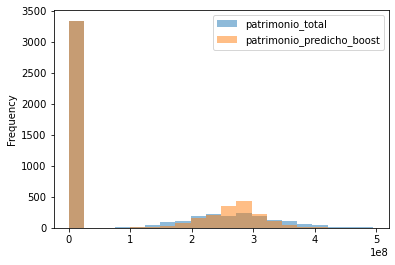

In [335]:
funcionarios_patrimonio.plot.hist(y=['patrimonio_total', 'patrimonio_predicho_boost'], bins=20, alpha=0.5)

<AxesSubplot:xlabel='patrimonio_total', ylabel='patrimonio_predicho_boost'>

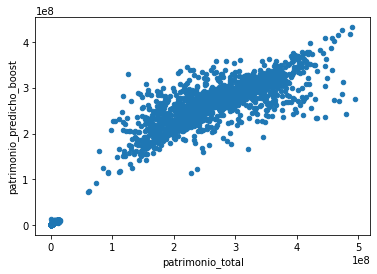

In [336]:
funcionarios_patrimonio.plot.scatter(x='patrimonio_total', y='patrimonio_predicho_boost')

<AxesSubplot:xlabel='n_obs', ylabel='patrimonio_predicho_boost'>

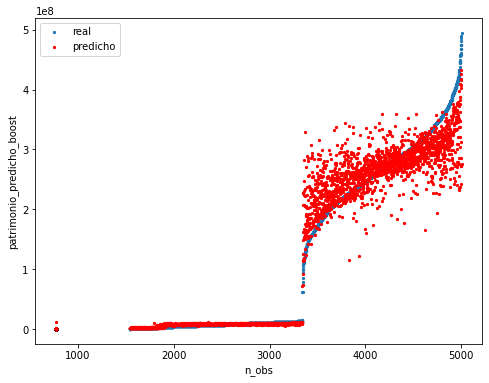

In [353]:
funcionarios_patrimonio['n_obs'] = funcionarios_patrimonio['patrimonio_total'].rank().astype(int)
ax = funcionarios_patrimonio.plot.scatter(y='patrimonio_total', x='n_obs', marker='.', figsize=(8, 6), label='real')
funcionarios_patrimonio.plot.scatter(y='patrimonio_predicho_boost', x='n_obs', marker='.', ax=ax, color='red', label='predicho')

# Base final anomalías

In [462]:
#decl = pd.read_pickle(f'{dir_declaraciones}/declaraciones_2021.pkl').sort_values(['curp', 'metadata.actualizacion'])

decl['nombre'] = decl[['declaracion.situacionPatrimonial.datosGenerales.nombre',
      'declaracion.situacionPatrimonial.datosGenerales.primerApellido', 
      'declaracion.situacionPatrimonial.datosGenerales.segundoApellido']].add(' ').sum(axis=1).str.strip()

decl['nivelOrdenGobierno'] = decl['declaracion.situacionPatrimonial.datosEmpleoCargoComision.nivelOrdenGobierno'].replace({'MUNICIPAL_ALCALDIA': 'MUNICIPAL'})
decl['year'] = decl['metadata.actualizacion'].str[0:4].astype(int)
vars_funcionario = ['curp', 'nombre', 'metadata.institucion', 'nivelOrdenGobierno', 'declaracion.situacionPatrimonial.datosEmpleoCargoComision.areaAdscripcion',
                    'declaracion.situacionPatrimonial.datosEmpleoCargoComision.nivelEmpleoCargoComision',
                    'declaracion.situacionPatrimonial.datosEmpleoCargoComision.empleoCargoComision',
                    'declaracion.situacionPatrimonial.datosPareja.curp',
                    
                   ]
df_funcionarios = decl[vars_funcionario].drop_duplicates(subset=['curp'])
df_funcionarios.head(2)

,curp,nombre,metadata.institucion,nivelOrdenGobierno,declaracion.situacionPatrimonial.datosEmpleoCargoComision.areaAdscripcion,declaracion.situacionPatrimonial.datosEmpleoCargoComision.nivelEmpleoCargoComision,declaracion.situacionPatrimonial.datosEmpleoCargoComision.empleoCargoComision,declaracion.situacionPatrimonial.datosPareja.curp
24437,ABAF800309HPURÑT08,Fatima Abreu Acuña,SERVICIO DE PROTECCIÓN FEDERAL,FEDERAL,Dirección General de Administración,O32,Jefe de Departamento,GRCM720103HAGRRR03
19303,ABAG780123HVZYRL05,Gilberto Abeyta Adorno,COMISION NACIONAL DEL SISTEMA DE AHORRO PARA E...,ESTATAL,Unidad de Asuntos Jurídicos,18,Director General Paraestatal B,ÁGCG781018HSNLNL01


* La pareja de ningún funcionario también es funcionaria

In [463]:
df_funcionarios['declaracion.situacionPatrimonial.datosPareja.curp'].isin(df_funcionarios['curp'].values).sum()

0

* Ningún dependiente de un funcionario también es funcionario

In [475]:
dependientes['curp'].isin(df_funcionarios['curp'].values).sum()

0

In [139]:
ingreso_total_neto = decl.pivot_table(index='curp', columns='year', values='declaracion.situacionPatrimonial.ingresos.totalIngresosAnualesNetos.valor').loc[:, [2015, 2016, 2017, 2018, 2019, 2020]]\
    .add_prefix('ingreso_total_neto_')\
    .reset_index()
ingreso_total_neto.head()

year,curp,ingreso_total_neto_2015,ingreso_total_neto_2016,ingreso_total_neto_2017,ingreso_total_neto_2018,ingreso_total_neto_2019,ingreso_total_neto_2020
0,ABAF800309HPURÑT08,105560.0,506688.0,506688.0,506688.0,506688.0,506688.0
1,ABAG780123HVZYRL05,1514535.0,4854048.0,6030672.0,5115900.0,5262936.0,4329060.0
2,ABAM750311HPURCR03,125000.0,600000.0,600000.0,600000.0,600000.0,600000.0
3,ABAM881010MDFYVT07,357725.0,1624440.0,1595808.0,1698564.0,1631928.0,1588536.0
4,ABBA870314MSNRRN07,315750.0,1314072.0,1106616.0,1302660.0,1179192.0,1177404.0


* creamos variable que indica si funcionario fue sancionado y si participaba en compras públicas

In [450]:
df_fun_contra = pd.read_pickle(f'{dir_declaraciones}/funcionarios_contrataciones_2021.pkl')\
    .rename(columns={'superiorInmediato.curp': 'curp_jefe'})
df_fun_sanc = pd.read_pickle(f'{dir_declaraciones}/funcionarios_sancionados_2021.pkl')\
    .rename(columns={'servidorPublicoSancionado.curp': 'curp'})

df_decl_sanc = decl[['curp']].drop_duplicates()\
    .merge(df_fun_sanc[['curp', 'expediente']], on='curp', how='left')\
    .merge(df_fun_contra[['curp']].drop_duplicates(), on='curp', how='left', indicator='merge_contra')\
    .assign(
    sancionado=lambda x: x['expediente'].notnull().astype(int),
    participa_contrataciones=lambda x: x['merge_contra'].eq('both').astype(int),
    sancionado_contrataciones=lambda x: x['sancionado'] * x['participa_contrataciones']
           )\
    .drop(['expediente', 'merge_contra', 'participa_contrataciones'], axis=1)\
    .add_prefix('red_flag_')\
    .rename(columns={'red_flag_curp': 'curp'})

df_decl_sanc.to_pickle(f'{dir_declaraciones}/anomalias_sancionados.pkl')
df_decl_sanc.head()

,curp,red_flag_sancionado,red_flag_sancionado_contrataciones
0,ABAF800309HPURÑT08,0,0
1,ABAG780123HVZYRL05,0,0
2,ABAM750311HPURCR03,0,0
3,ABAM881010MDFYVT07,0,0
4,ABBA870314MSNRRN07,0,0


In [435]:
df_decl_sanc['participa_contrataciones'].sum()

2463

* Anomalías en el monto declarado, dado el perfil Estas las calculó Dani basada en los resultados del modelo de ML

In [449]:
anomalias_patrimonio_perfil = pd.read_csv(f'{dir_declaraciones}/anomalias_patrimonio_red_flags.csv')\
    .add_suffix('_patrimonio').rename(columns={'curp_patrimonio': 'curp'})
anomalias_patrimonio_perfil.head()

,curp,red_flag_bajo_patrimonio,red_flag_alto_patrimonio,red_flag_cero_patrimonio
0,ABAF800309HPURÑT08,0,0,0
1,ABAG780123HVZYRL05,0,0,0
2,ABAM750311HPURCR03,0,0,0
3,ABAM881010MDFYVT07,1,0,0
4,ABBA870314MSNRRN07,0,0,0


* Anomalías de evolución de ingreso y patrimonio

In [452]:
anomalias_ingreso_evolucion = pd.read_csv(f'{dir_declaraciones}/anomalias_evolucion_ingreso_red_flag.csv')
anomalias_ingreso_evolucion.head()

,metadata.institucion,curp,no_anomalias,red_flag_evolucion_ingreso
0,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,ALKE700221MSNCRM08,0,False
1,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,CABT861110HDFRRR09,0,False
2,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,DURM850624HVZÑZR01,0,False
3,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,GAAP830802HSNRYL07,2,True
4,ADMINISTRACION DEL PATRIMONIO DE LA BENEFICENC...,GUGI800004HAGTRR08,0,False


In [478]:
anomalias_patrimonio_evolucion = pd.read_csv(f'{dir_declaraciones}/anomalias_evolucion_patrimonio_red_flag.csv')\
    .sort_values(['curp', 'desviacion_patrimonio'], ascending=False).drop_duplicates('curp')
anomalias_patrimonio_evolucion.head()

,curp,desviacion_patrimonio,red_flag_desviacion,prop,red_flag_lib_fin
3254,ÑAUM890715HAGÑRR09,0.071517,False,8.497741,False
2011,ÑAPI720724MDFÑÑB01,0.123334,False,0.000000,False
2262,ÑADF840827HDFÑLL08,0.109464,False,7.357081,False
2356,ÑACY720312MSNÑRR06,0.104639,False,0.000000,False
3835,ÁVVE760127MDFLLT04,0.057197,False,38.111532,False


In [508]:
funcionarios_patrimonio = df_funcionarios\
    .merge(resumen_edu, on='curp', how='left')\
    .merge(resumen_experiencia, on='curp', how='left')\
    .merge(resumen_vehiculos, on='curp', how='left')\
    .merge(resumen_bienes, on='curp', how='left')\
    .merge(resumen_inversiones, on='curp', how='left')\
    .assign(patrimonio_total=lambda x: x['valor_bienes'] + x['valor_vehiculos'] + x['valor_inversiones'])\
    .merge(ingreso_total_neto, on='curp', how='left')\
    .merge(df_decl_sanc, on='curp', how='left')\
    .merge(anomalias_patrimonio_perfil, on='curp', how='left')\
    .merge(anomalias_ingreso_evolucion, on='curp', how='left')\
    .merge(anomalias_patrimonio_evolucion, on='curp', how='left')\
    .merge(anomalia_isol, on='curp', how='left')\
    .fillna(0)

funcionarios_patrimonio.to_csv(f'{dir_declaraciones}/datos_funcionarios_2021.csv', index=False)
funcionarios_patrimonio.to_pickle(f'{dir_declaraciones}/datos_funcionarios_2021.pkl')
funcionarios_patrimonio.head()

,curp,nombre,metadata.institucion_x,nivelOrdenGobierno,declaracion.situacionPatrimonial.datosEmpleoCargoComision.areaAdscripcion,declaracion.situacionPatrimonial.datosEmpleoCargoComision.nivelEmpleoCargoComision,declaracion.situacionPatrimonial.datosEmpleoCargoComision.empleoCargoComision,declaracion.situacionPatrimonial.datosPareja.curp,edu_nivel,edu_doc,edu_esp,edu_lic,edu_mae,exp_privado,exp_publico,exp_total,n_vehiculos,n_vehiculos_lujo,valor_vehiculos,n_bienes,valor_bienes,valor_inversiones,patrimonio_total,ingreso_total_neto_2015,ingreso_total_neto_2016,ingreso_total_neto_2017,ingreso_total_neto_2018,ingreso_total_neto_2019,ingreso_total_neto_2020,red_flag_sancionado,red_flag_sancionado_contrataciones,red_flag_bajo_patrimonio,red_flag_alto_patrimonio,red_flag_cero_patrimonio,metadata.institucion_y,no_anomalias,red_flag_evolucion_ingreso,desviacion_patrimonio,red_flag_desviacion,prop,red_flag_lib_fin,anomalia_isol
0,ABAF800309HPURÑT08,Fatima Abreu Acuña,SERVICIO DE PROTECCIÓN FEDERAL,FEDERAL,Dirección General de Administración,O32,Jefe de Departamento,GRCM720103HAGRRR03,LICENCIATURA,0,0,1,0,12.1,0.0,12.1,6.0,2.0,695333.0,0.0,0.0,10954.0,0.0,105560.0,506688.0,506688.0,506688.0,506688.0,506688.0,0,0,0,0,0,SERVICIO DE PROTECCIÓN FEDERAL,0.0,False,0.231440,False,0.000000,False,0
1,ABAG780123HVZYRL05,Gilberto Abeyta Adorno,COMISION NACIONAL DEL SISTEMA DE AHORRO PARA E...,ESTATAL,Unidad de Asuntos Jurídicos,18,Director General Paraestatal B,ÁGCG781018HSNLNL01,DOCTORADO,1,1,1,0,12.3,0.0,12.3,5.0,2.0,4359275.0,2.0,170266978.0,59315459.0,233941712.0,1514535.0,4854048.0,6030672.0,5115900.0,5262936.0,4329060.0,0,0,0,0,0,COMISION NACIONAL DEL SISTEMA DE AHORRO PARA E...,1.0,True,0.011267,False,54.039841,False,1
2,ABAM750311HPURCR03,Marcela Abreu Alcántar,ADMINISTRACION PORTUARIA INTEGRAL DE DOS BOCAS...,MUNICIPAL,Dirección General de Vinculación,A33,Analista,ACAF840803MAGÑRL08,LICENCIATURA,0,0,1,0,6.2,3.9,10.1,7.0,0.0,1646379.0,0.0,0.0,10186.0,0.0,125000.0,600000.0,600000.0,600000.0,600000.0,600000.0,0,0,0,0,0,ADMINISTRACION PORTUARIA INTEGRAL DE DOS BOCAS...,0.0,False,0.315902,False,0.000000,False,0
3,ABAM881010MDFYVT07,Matías Abeyta Alvarado,"FONATUR OPERADORA PORTUARIA, S.A. DE C.V.",ESTATAL,Unidad de Transparencia,M34,Administrador,PUCC781025MAGLRR01,LICENCIATURA,0,0,1,0,10.4,0.0,10.4,4.0,1.0,1756205.0,1.0,2605031.0,827536.0,5188772.0,357725.0,1624440.0,1595808.0,1698564.0,1631928.0,1588536.0,0,0,1,0,0,"FONATUR OPERADORA PORTUARIA, S.A. DE C.V.",0.0,False,0.191379,False,3.266386,False,0
4,ABBA870314MSNRRN07,Adán Abrego Bernal,TRANSPORTADORA DE SAL S.A. DE C.V.,MUNICIPAL,Unidad de Asuntos Jurídicos,N34,Subadministrador,VIVE740505HDFLLL01,MAESTRÍA,0,0,1,1,10.2,0.0,10.2,6.0,0.0,2657856.0,1.0,4937025.0,822358.0,8417239.0,315750.0,1314072.0,1106616.0,1302660.0,1179192.0,1177404.0,0,0,0,0,0,TRANSPORTADORA DE SAL S.A. DE C.V.,0.0,False,0.092459,False,7.148981,False,0


In [509]:
funcionarios_patrimonio.shape

(5005, 42)

In [468]:
anomalias_patrimonio_evolucion.shape

(25017, 5)

In [482]:
decl.shape

(40019, 261)